# Cytoscape v3.5 CyREST Challenge
## Dynamic visualization of kinetic models in Cytoscape
This notebook contains a python workflow for the visualization kinetic model simulations within Cytoscape networks.

In this workflow 

* kinetic models encoded in the Systems Biology Markup Language [SBML](http://www.sbml.org) are loaded
* kinetic model simulations are performed 
* timecourse results are mapped on the corresponding Cytoscape networks which are read using the Cytoscaoe app `cy3sbml`. 

This workflow demonstrates how simulation results from computational models can be easily mapped on their model graph. By using `cy3sbml` simulation results in the graph are annotated with the information available from the SBML file, e.g. ontology information or metadata on parameters, species and reactions.

The workflow uses a classical example model, the Elowitz Repressilator, with simulations resulting in an oscillatory change of the main players, three mRNA's and their respective protein levels.

This workflow is valuable because it allows the automatic visualization of simulation results within the underlying biological network of the computational model. A wide range of models is available in SBML and the workflow can consequently be adapted easily to other use cases.

* **solver**: Matthias König 
* **repository**: https://github.com/matthiaskoenig/cyrest-challenge

Information on how to setup the python environment for executing this notebook is provided in:  
https://github.com/matthiaskoenig/cyrest-challenge/blob/master/README.md

## Start Cytoscape 3 with cyrest & cy3sbml apps
Before executing this notebook start `Cytoscape>=3.5.1` with the following apps installed

* `cyrest-app>=3.5.0` (http://apps.cytoscape.org/apps/cyrest)
* `cy3sbml>=0.2.5` (http://apps.cytoscape.org/apps/cy3sbml)

In [1]:
from __future__ import print_function, division
import pandas as pd
from matplotlib import pylab as plt
import roadrunner  
%matplotlib inline

# some settings for the plots
plt.rcParams.update({
        'axes.labelsize': 'large',
        'axes.labelweight': 'bold',
        'axes.titlesize': 'large',
        'axes.titleweight': 'bold',
        'legend.fontsize': 'small',
        'xtick.labelsize': 'large',
        'ytick.labelsize': 'large',
    })

## Load SBML model
In the following we load the **Elowitz2000 model, a synthetic oscillatory network of transcriptional regulators** and user roadrunner, a high performance SBML simulator, to simulate the model. The model was downloaded from Biomodels as [BIOMD0000000012](https://www.ebi.ac.uk/biomodels-main/BIOMD0000000012).

This model describes the deterministic version of the repressilator system. The authors of this model (see reference) use three transcriptional repressor systems that are not part of any natural biological clock to build an oscillating network that they called the repressilator. The model system was induced in Escherichia coli.

In this system, **LacI (variable X is the mRNA, variable PX is the protein)** inhibits the tetracycline-resistance transposon **tetR (Y, PY describe mRNA and protein)**. Protein tetR inhibits the **gene Cl from phage Lambda (Z, PZ: mRNA, protein)**,and protein Cl inhibits lacI expression. 
**With the appropriate parameter values this system oscillates.**

This model is described in the article:  
A synthetic oscillatory network of transcriptional regulators.  
Elowitz MB, Leibler S.  
Nature. 2000 Jan; 403(6767):335-338  

Abstract:

Networks of interacting biomolecules carry out many essential functions in living cells, but the 'design principles' underlying the functioning of such intracellular networks remain poorly understood, despite intensive efforts including quantitative analysis of relatively simple systems. Here we present a complementary approach to this problem: the design and construction of a synthetic network to implement a particular function. We used three transcriptional repressor systems that are not part of any natural biological clock to build an oscillating network, termed the repressilator, in Escherichia coli. The network periodically induces the synthesis of green fluorescent protein as a readout of its state in individual cells. The resulting oscillations, with typical periods of hours, are slower than the cell-division cycle, so the state of the oscillator has to be transmitted from generation to generation. This artificial clock displays noisy behaviour, possibly because of stochastic fluctuations of its components. Such 'rational network design may lead both to the engineering of new cellular behaviours and to an improved understanding of naturally occurring networks.

In [2]:
# high performance SBML simulator
import roadrunner
sbml_model = "./models/BIOMD0000000012.xml"
r = roadrunner.RoadRunner(sbml_model)
model = r.getModel()

## Simulate SBML model
In the following we perform a simple timecourse simulation which we than visualize in the `cy3sbml` Cytoscape network. The numerical results are stored in a `pandas DataFrame`. In the following the `sbml ids`, which we use for mapping on the Cytoscape network, and the first rows of the numerical solution are depicted.

After this simulation step we have numerical time course data, which is used in the following to map on the network.

In [3]:
# reset the model
r.reset()

# select ids in numerical simulation
r.timeCourseSelections = ['time'] + model.getFloatingSpeciesIds() + model.getReactionIds()
# integration
data = r.simulate(start=0, end=200, steps=100)

# sbml ids from timeCourseSelections
sbml_ids = [name.replace("[", "").replace("]", "") 
            for name in r.timeCourseSelections]
print(sbml_ids)

# create pandas dataframe
df = pd.DataFrame(data[:, 1:], index=data[:,0], columns=sbml_ids[1:])
df.to_csv("./results/simulation.tsv", sep='\t')
df.head(10)

['time', 'PX', 'PY', 'PZ', 'X', 'Y', 'Z', 'Reaction1', 'Reaction2', 'Reaction3', 'Reaction4', 'Reaction5', 'Reaction6', 'Reaction7', 'Reaction8', 'Reaction9', 'Reaction10', 'Reaction11', 'Reaction12']


,PX,PY,PZ,X,Y,Z,Reaction1,Reaction2,Reaction3,Reaction4,Reaction5,Reaction6,Reaction7,Reaction8,Reaction9,Reaction10,Reaction11,Reaction12
0.0,0.000000,0.000000,0.000000,0.000000,20.000000,0.000000,0.000000,6.931472,0.000000,0.000000,138.629436,0.000000,0.000000,0.000000,0.000000,30.000000,30.000000,30.000000
2.0,218.538704,358.026782,84.588884,21.233519,23.608864,5.866252,7.358977,8.182209,2.033088,147.179535,163.644178,40.661761,15.147949,24.816525,5.863255,5.506924,1.001491,0.399478
4.0,428.938247,536.662776,131.034639,15.559774,12.482022,3.295798,5.392607,4.325939,1.142237,107.852138,86.518783,22.844734,29.731734,37.198629,9.082629,2.584705,0.288379,0.195576
6.0,542.465621,585.396059,146.531395,11.033627,6.564237,1.902649,3.823964,2.274991,0.659408,76.479273,45.499826,13.188161,37.600852,40.576563,10.156782,2.108413,0.192072,0.169279
8.0,596.569596,572.333053,146.992677,8.518859,3.533290,1.198351,2.952412,1.224545,0.415317,59.048232,24.490899,8.306337,41.351053,39.671104,10.188756,2.096287,0.164133,0.175678
10.0,621.043069,532.672172,141.004085,7.402872,1.994072,0.869004,2.565640,0.691093,0.301174,51.312801,13.821851,6.023478,43.047425,36.922021,9.773658,2.262179,0.153813,0.198052
12.0,634.159346,483.803127,133.027345,7.161642,1.214618,0.747167,2.482036,0.420955,0.258948,49.640722,8.419092,5.178965,43.956576,33.534677,9.220753,2.515039,0.148764,0.233475
14.0,646.192780,433.991078,125.380804,7.436776,0.818490,0.748080,2.577390,0.283667,0.259265,51.547804,5.673340,5.185292,44.790670,30.081969,8.690735,2.798536,0.144399,0.282448
16.0,662.189607,386.907860,119.309186,7.970971,0.613361,0.831366,2.762528,0.212575,0.288129,55.250561,4.251495,5.762590,45.899486,26.818409,8.269883,3.058289,0.138958,0.346938
18.0,683.569249,343.956441,115.546919,8.554609,0.501896,0.980501,2.964802,0.173944,0.339816,59.296034,3.478881,6.796315,47.381410,23.841244,8.009102,3.237258,0.132272,0.429913


## Plot numerical solution
Now we plot the solution to show the oscillating behavior of the system. 
mRNA and Protein levels of the system oscillate over time, with mRNA concentrations much lower than the protein amount (which can be seen on the log axis).

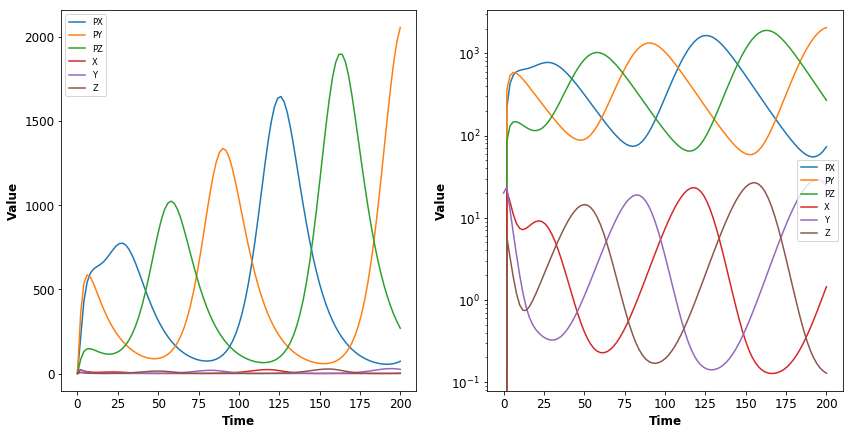

In [4]:
# The system oscillates
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
axes = (ax1, ax2)

for ax in axes:
    for sid in ['PX', 'PY', 'PZ', 'X', 'Y', 'Z']:
        ax.plot(df.index, df[sid], label=sid)
ax2.set_yscale('log')
for ax in axes:
    ax.set_ylabel('Value')
    ax.set_xlabel('Time')
    ax.legend()

plt.show()
fig.savefig("./results/simulation.png", bbox_inches='tight')

## Load SBML model in Cytoscape
On basis of the numerical results we do not understand the connection between the different mRNA and Proteins in this negative feedback model. For a better understanding what is going on we visualize the graph structure of the model.

In [5]:
import json
import py2cytoscape
from py2cytoscape.data.cyrest_client import CyRestClient
from py2cytoscape.data.cynetwork import CyNetwork
from py2cytoscape.data.style import StyleUtil

# new cyrest client
cy = CyRestClient()

# reset Cytoscape session
cy.session.delete()

In [6]:
# load SBML network (this uses cy3sbml)
networks = cy.network.create_from('./models/BIOMD0000000012.xml')
print(networks)

[<py2cytoscape.data.cynetwork.CyNetwork object at 0x7f6520059748>, <py2cytoscape.data.cynetwork.CyNetwork object at 0x7f651b32e6a0>, <py2cytoscape.data.cynetwork.CyNetwork object at 0x7f651b32e390>]


After loading SBML models with cy3sbml three different networks are generated
* All: contains all SBML information of the model (i.e. kinetics graph with units)
* Kinetics: contains SBML information about the kinetics and relations to model components
* Base: basic species-reaction graph of SBML (with additional GeneProducts if in the model)

In the following we are mainly interested in the `species-reaction` graph of SBML which corresponds to 
* species: mRNA and protein
* reactions: translation, transcription and mRNA/Protein degradation

In the following we select the base network

In [7]:
# Get information about SBML networks
base_net = None
for net in networks:
    # unique id of cytoscape objects
    net_suid = net.get_id()
    net_name = net.get_network_value(column='name')
    print(net.get_network_value(column='name'))
    if (net_name.startswith(b'Base')):
        base_net = net

# Selected the Base network (reaction - species graph of sbml file)
print('-'*60)
print (base_net)
print('-'*60)

b'All: Elowitz2000 - Repressilator'
b'Base: Elowitz2000 - Repressilator'
b'Kinetic: Elowitz2000 - Repressilator'
------------------------------------------------------------
------------------------------------------------------------


## Display the reaction-species graph
Here we display the core model graph. With this figure it becomes more clear what is happening in the model and we clearly see the negative feedback cycle of the proteins on the transcription of the following proteins in the cycle.

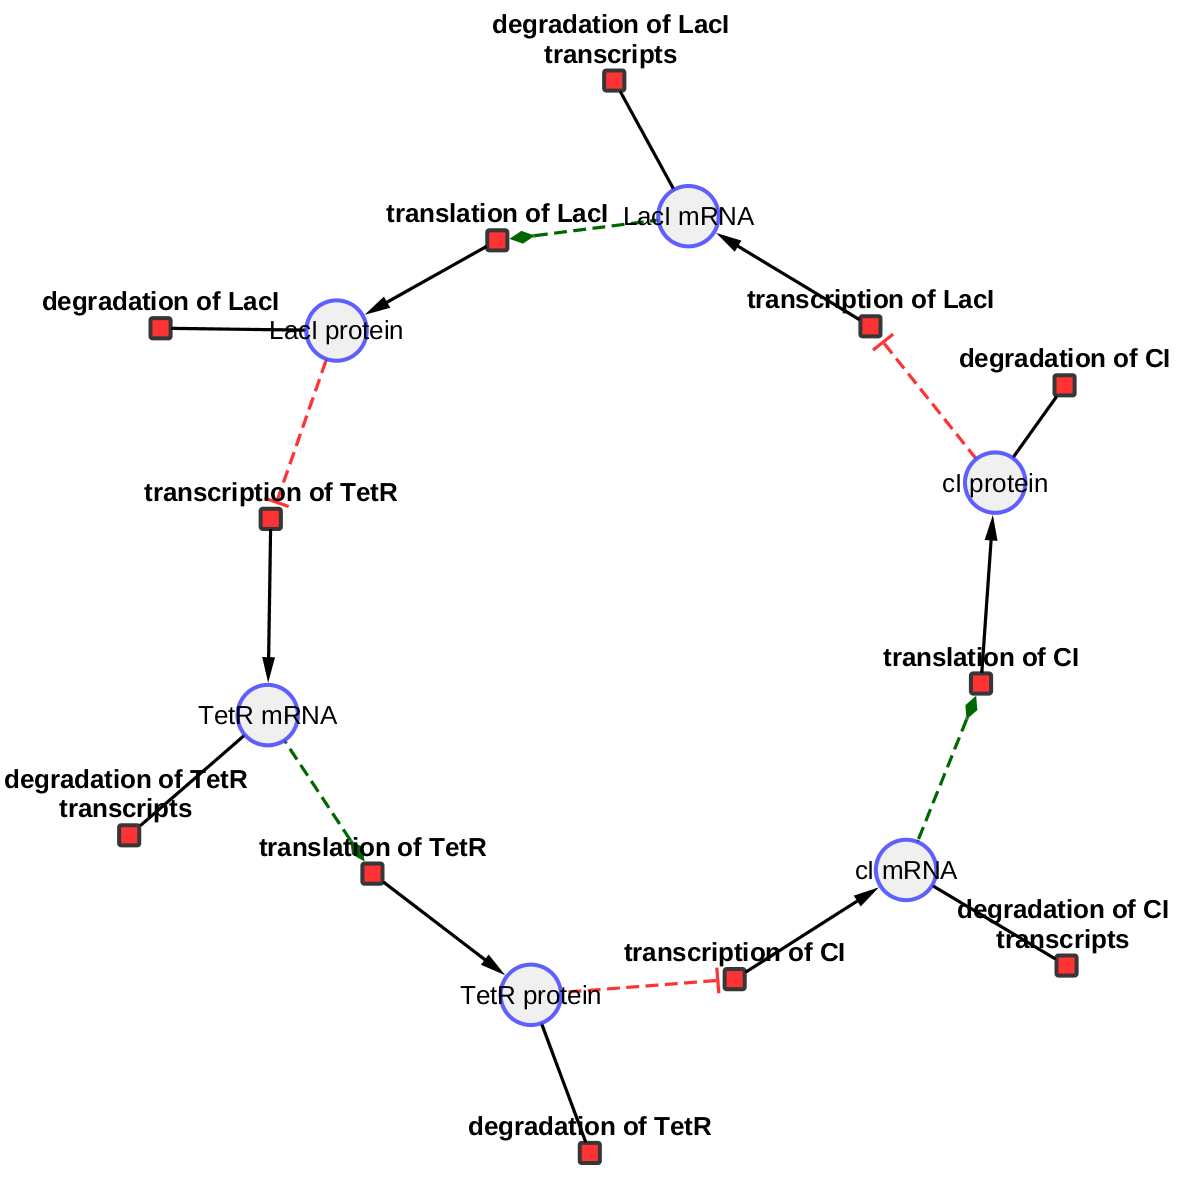

In [8]:
# Adjust the node positions in Cytoscape and create the figure
from IPython.display import Image
Image(base_net.get_png())

## Mapping of simulation results to Cytoscape VisualStyle
### cy3sbml node table
All cy3sbml table attributes are easily accessible from python. In the following we load the node table to find the nodes which correspond the the `sbml ids` in the simulation.

In [9]:
# cell = base_net.get_node_value(id=node0, column='name')
node_table = base_net.get_node_table()
node_table

,shared name,cyId,sbml type,label,metaId,unitSid,kind,scale,multiplier,sbo,...,chebi,kegg.compound,reversible,math,kineticLaw,variable,compartmentCode,sbml type ext,name,selected
SUID,,,,,,,,,,,,,,,,,,,,,
2415,transcription of TetR,_906022,reaction,transcription of TetR,_906022,NaN,NaN,NaN,NaN,SBO:0000183,...,NaN,NaN,False,NaN,a0_tr+a_tr*KM^n/(KM^n+PX^n),NaN,NaN,reaction irreversible,transcription of TetR,False
2354,degradation of TetR transcripts,_905842,reaction,degradation of TetR transcripts,_905842,NaN,NaN,NaN,NaN,SBO:0000179,...,NaN,NaN,False,NaN,kd_mRNA*Y,NaN,NaN,reaction irreversible,degradation of TetR transcripts,False
2387,degradation of LacI,_905943,reaction,degradation of LacI,_905943,NaN,NaN,NaN,NaN,SBO:0000179,...,NaN,NaN,False,NaN,kd_prot*PX,NaN,NaN,reaction irreversible,degradation of LacI,False
2360,degradation of CI transcripts,_905862,reaction,degradation of CI transcripts,_905862,NaN,NaN,NaN,NaN,SBO:0000179,...,NaN,NaN,False,NaN,kd_mRNA*Z,NaN,NaN,reaction irreversible,degradation of CI transcripts,False
2425,transcription of CI,_906042,reaction,transcription of CI,_906042,NaN,NaN,NaN,NaN,SBO:0000183,...,NaN,NaN,False,NaN,a0_tr+a_tr*KM^n/(KM^n+PY^n),NaN,NaN,reaction irreversible,transcription of CI,False
2393,degradation of TetR,_905962,reaction,degradation of TetR,_905962,NaN,NaN,NaN,NaN,SBO:0000179,...,NaN,NaN,False,NaN,kd_prot*PY,NaN,NaN,reaction irreversible,degradation of TetR,False
2366,translation of LacI,_905882,reaction,translation of LacI,_905882,NaN,NaN,NaN,NaN,SBO:0000184,...,NaN,NaN,False,NaN,k_tl*X,NaN,NaN,reaction irreversible,translation of LacI,False
2399,degradation of CI,_905982,reaction,degradation of CI,_905982,NaN,NaN,NaN,NaN,SBO:0000179,...,NaN,NaN,False,NaN,kd_prot*PZ,NaN,NaN,reaction irreversible,degradation of CI,False
2336,LacI protein,PX,species,LacI protein,PX,NaN,NaN,NaN,NaN,SBO:0000252,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,species,LacI protein,False


### Find nodes for sbml ids
We now find the nodes which correspond to the species we simulated in the model.
The suid (unique node identifiers) are retrieved and stored for lookup.

In [10]:
node_suids = []

# logical indexing to find the nodes
for sid in sbml_ids[1:]:
    suid_index = node_table[node_table["sbml id"]==sid].index
    node_suids.append(suid_index.get_values()[0])

suid2sid = dict(zip(node_suids, sbml_ids[1:]))
suid2sid

{2336: 'PX',
 2338: 'PY',
 2340: 'PZ',
 2342: 'X',
 2344: 'Y',
 2346: 'Z',
 2348: 'Reaction1',
 2354: 'Reaction2',
 2360: 'Reaction3',
 2366: 'Reaction4',
 2373: 'Reaction5',
 2380: 'Reaction6',
 2387: 'Reaction7',
 2393: 'Reaction8',
 2399: 'Reaction9',
 2405: 'Reaction10',
 2415: 'Reaction11',
 2425: 'Reaction12'}

### Map kinetic data to Visual Style

Now we map the kinetic simulation results on the VisualStyle of the Cytoscape network.
We use the `NODE_HEIGHT` and `NODE_WIDTH` for mapping of the protein and mRNA concentrations.

In [11]:
# get network view
view_id_list = base_net.get_views() 
base_view = base_net.get_view(view_id_list[0], format='view')
print(base_view)

In [12]:
# create cytoscape images of timepoints
# the species amounts and reaction rates are mapped to the node sizes
from py2cytoscape.data.util_network import NetworkUtil as util
import time
import os
import numpy as np

# DataFrame for node views
df_vs_node = pd.DataFrame(index=node_suids, 
                  columns=['NODE_WIDTH', 'NODE_HEIGHT'])
# create cytoscape figure for timepoint
cypng_files = []
for timepoint in df.index:
    
    # set all node heights & widths
    for index, row in df_vs_node.iterrows():
        sbml_id = suid2sid.get(index)
        
        # Set node size from simulation results
        # area of nodes should be proportional to concentration, i.e. A^2 ~ H*W = H^2 = c
        row['NODE_WIDTH'] = np.sqrt(df.loc[timepoint, sbml_id])*3
        row['NODE_HEIGHT'] = np.sqrt(df.loc[timepoint, sbml_id])*3
        
        # normalisation with max value
        # row['NODE_WIDTH'] = 80 * df.loc[timepoint, sbml_id]/max(df[sbml_id])
        # row['NODE_HEIGHT'] = 80 * df.loc[timepoint, sbml_id]/max(df[sbml_id])

    # Apply style for timepoint
    base_view.batch_update_node_views(df_vs_node)
    
    cypng_data = base_net.get_png()
    cypng_file = "./results/images/cytime_{}.png".format(int(timepoint))
    cypng_files.append(cypng_file)
    
    if True:
        # write images
        with open(cypng_file, "wb") as f:
            f.write(cypng_data)
    else:
        # wait
        time.sleep(0.01)

In [13]:
# create kinetic plots for the respective timepoints
mplpng_files = []
for timepoint in df.index:
         
    # create matplotlib figure for timepoint
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

    for sid in ['PX', 'PY', 'PZ', 'X', 'Y', 'Z']:
        ax.plot(df.index, df[sid], label=sid, linewidth=2)
    ax.plot([timepoint, timepoint], [0,2500], label="__nolabel__", linewidth=2, color="black")
    ax.set_yscale('log')
    ax.set_ylabel('Value')
    ax.set_xlabel('Time')
    ax.legend()
    mplpng_file = "./results/images/mpltime_{}.png".format(int(timepoint)) 
    
    fig.savefig(mplpng_file, bbox_inches='tight')
    plt.close(fig)
    mplpng_files.append(mplpng_file)

In [14]:
# Combine kinetic plots and cytoscape images
from PIL import Image as PImage
compng_files =[]
for timepoint in df.index:
    # put smaller image in the center of cytoscape circle
    mplpng_file = "./results/images/mpltime_{}.png".format(int(timepoint)) 
    cypng_file = "./results/images/cytime_{}.png".format(int(timepoint))
    compng_file = "./results/images/comtime_{}.png".format(int(timepoint))

    background = PImage.open(cypng_file)
    foreground = PImage.open(mplpng_file)
    
    # calculate the inline position
    pos_x = int(1.0*background.width/2 - 1.0*foreground.width/2)
    pos_y = int(1.0*background.height/2 - 1.0*foreground.height/2)

    background.paste(foreground, (pos_x, pos_y), foreground)
    # background.show()
    background.save(compng_file)
    compng_files.append(compng_file)

In [15]:
# Create gif
import imageio
images = []
for filename in compng_files:
    images.append(imageio.imread(filename))
imageio.mimsave('./results/cytoscape-repressilator.gif', images)

## Display timecourse
Now we have finished the dynamic visualization of the time course in Cytoscape. The following gif shows the resulting model behavior. 
<img src="./results/cytoscape-repressilator.gif">

## Display example image
In the following is one of the example timepoints shown. The three proteins oscillate and peak in turns. As long as translation>degration for proteins the amount increases, when translation<degradation the amount of protein decreases.

The mRNA oscillates also but with much lower amounts.

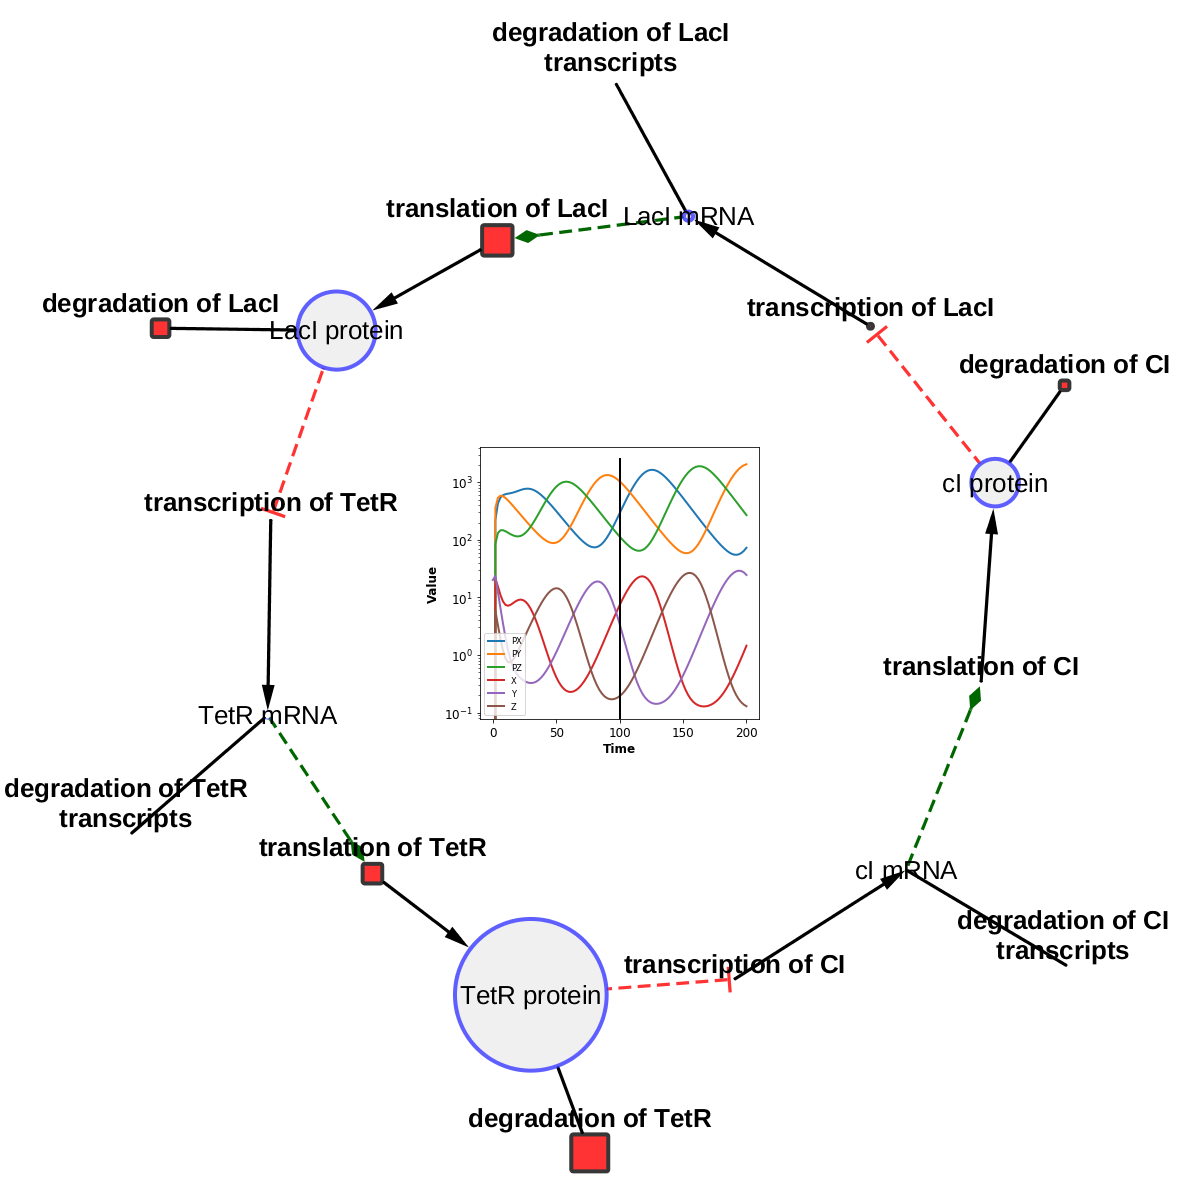

In [16]:
from IPython.display import Image
Image('./results/images/comtime_100.png')